<a href="https://colab.research.google.com/github/Beansente-ssi/Forecasting-COVID-19-Using-Bi-LSTM/blob/main/Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!pip install tensorflow-gpu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InLineBackend.figure_format = 'retina'

register_matplotlib_converters()
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
!gdown --id 123wQJw40rgoXhWHTn5JYPPJ91RG-V05K --output dataset.csv

Downloading...
From: https://drive.google.com/uc?id=123wQJw40rgoXhWHTn5JYPPJ91RG-V05K
To: /content/dataset.csv
100% 35.7k/35.7k [00:00<00:00, 31.4MB/s]


In [ ]:
df = pd.read_csv("dataset.csv", parse_dates=['date'], index_col = 'date')

In [ ]:
df.head()

,cases,norm_avg,precip_amt,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
date,,,,,,,,,
2020-03-27,2.0,28,0.0,-76.0,-57.0,-37.0,-72.0,-62.0,34.0
2020-03-28,0.0,28,0.0,-78.0,-60.0,-41.0,-73.0,-50.0,27.0
2020-03-29,1.0,28,0.0,-82.0,-67.0,-44.0,-76.0,-39.0,24.0
2020-03-30,0.0,28,0.0,-76.0,-60.0,-33.0,-72.0,-65.0,35.0
2020-03-31,0.0,28,0.0,-77.0,-60.0,-33.0,-72.0,-65.0,33.0


In [ ]:
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [ ]:
df.head()

,cases,norm_avg,precip_amt,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,day_of_week,day_of_month,month
date,,,,,,,,,,,,
2020-03-27,2.0,28,0.0,-76.0,-57.0,-37.0,-72.0,-62.0,34.0,4,27,3
2020-03-28,0.0,28,0.0,-78.0,-60.0,-41.0,-73.0,-50.0,27.0,5,28,3
2020-03-29,1.0,28,0.0,-82.0,-67.0,-44.0,-76.0,-39.0,24.0,6,29,3
2020-03-30,0.0,28,0.0,-76.0,-60.0,-33.0,-72.0,-65.0,35.0,0,30,3
2020-03-31,0.0,28,0.0,-77.0,-60.0,-33.0,-72.0,-65.0,33.0,1,31,3


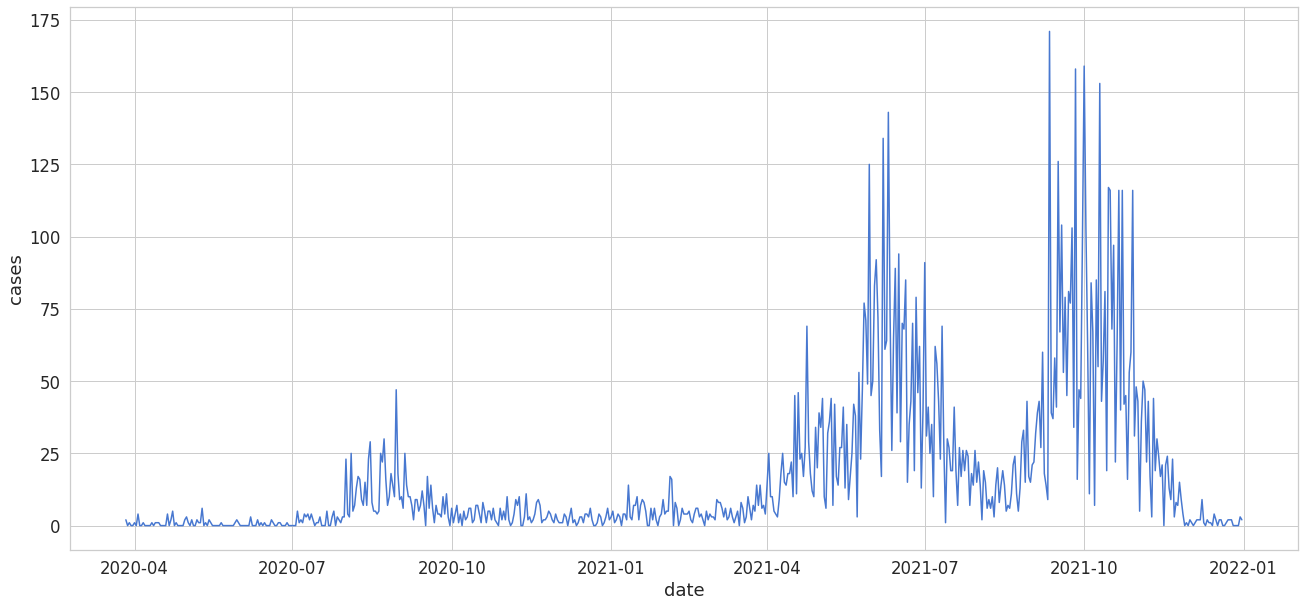

In [ ]:
sns.lineplot(x = df.index, y = 'cases', data = df)

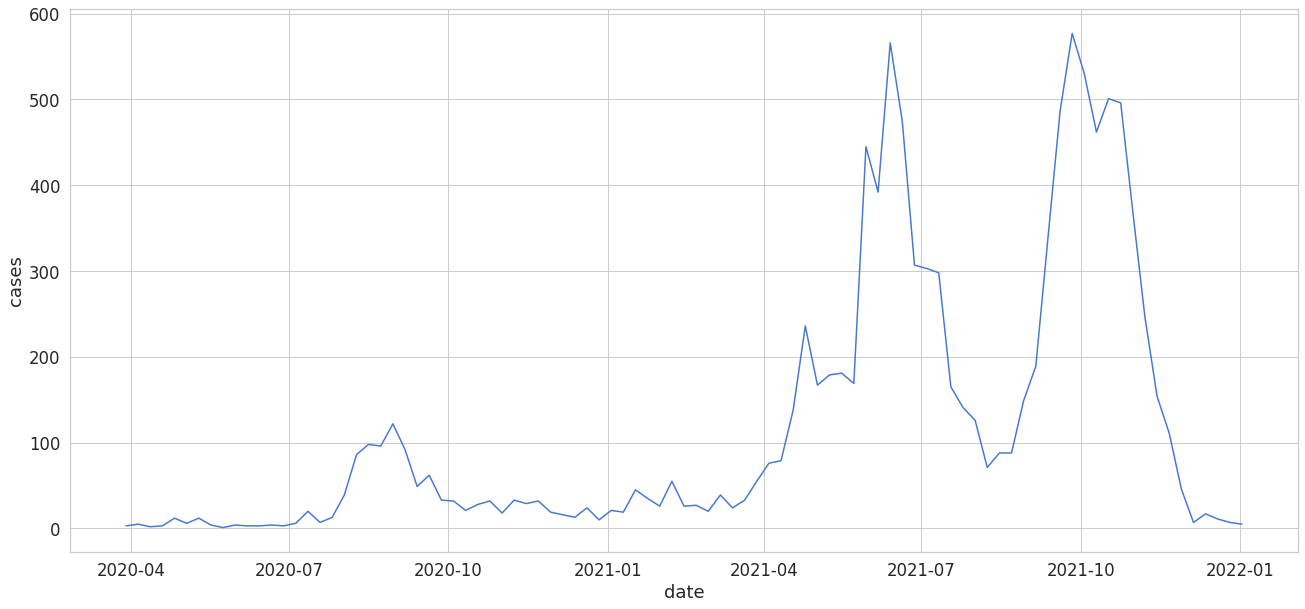

In [ ]:
df_by_week = df.resample('W').sum()
sns.lineplot(x = df_by_week.index, y = 'cases', data = df_by_week)

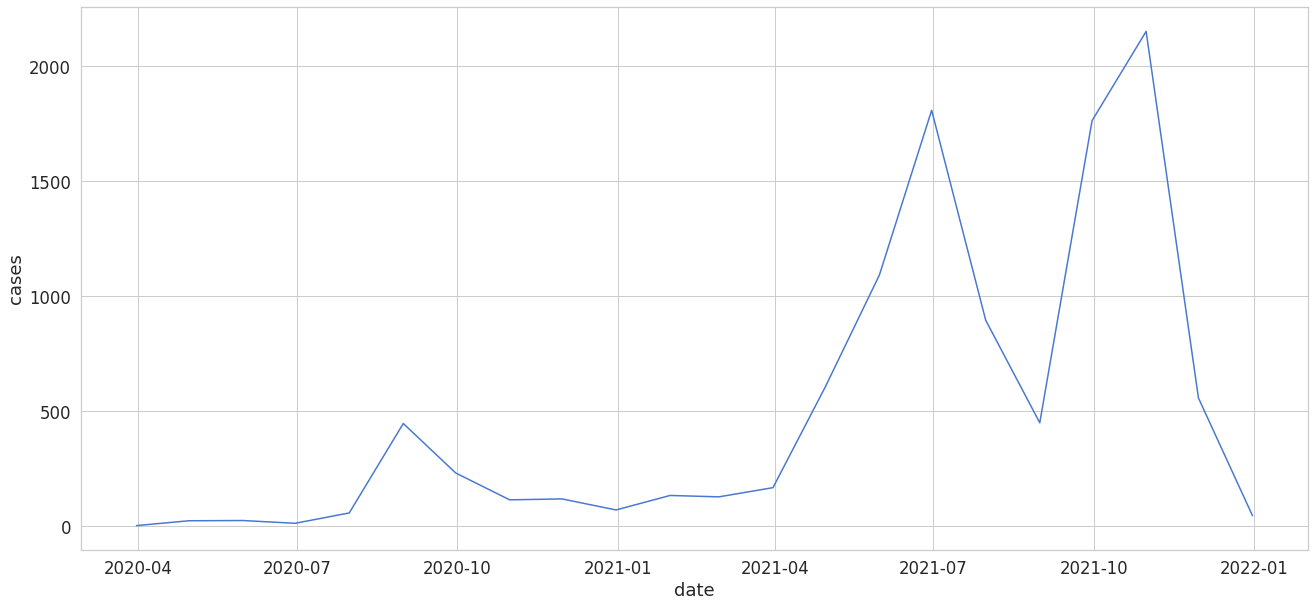

In [ ]:
df_by_month = df.resample('M').sum()
sns.lineplot(x = df_by_month.index, y = 'cases', data = df_by_month)

In [ ]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train , test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(580, 12) (65, 12)


In [ ]:
from sklearn.preprocessing import RobustScaler

f_columns = ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential']

f_transformer = RobustScaler()
cases_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cases_transformer = cases_transformer.fit(train[['cases']])

train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cases'] = cases_transformer.transform(train[['cases']])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cases'] = cases_transformer.transform(test[['cases']])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [ ]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i: (i + time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 24

X_train, y_train = create_dataset(train, train.cases, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test, test.cases, time_steps=TIME_STEPS)

In [ ]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=64,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
)

model.add(keras.layers.Dropout(rate = 0.2))
model.add(keras.layers.Dense(units = 1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
16/16 [==============================] - 7s 168ms/step - loss: 1.5689 - val_loss: 14.4914
Epoch 2/30
16/16 [==============================] - 1s 46ms/step - loss: 1.5230 - val_loss: 13.9590
Epoch 3/30
16/16 [==============================] - 1s 48ms/step - loss: 1.2743 - val_loss: 13.7236
Epoch 4/30
16/16 [==============================] - 1s 51ms/step - loss: 1.0904 - val_loss: 12.4166
Epoch 5/30
16/16 [==============================] - 1s 45ms/step - loss: 0.9763 - val_loss: 11.8073
Epoch 6/30
16/16 [==============================] - 1s 52ms/step - loss: 0.8594 - val_loss: 10.8413
Epoch 7/30
16/16 [==============================] - 1s 48ms/step - loss: 0.8205 - val_loss: 9.9900
Epoch 8/30
16/16 [==============================] - 1s 43ms/step - loss: 0.7911 - val_loss: 9.8927
Epoch 9/30
16/16 [==============================] - 1s 45ms/step - loss: 0.6946 - val_loss: 9.2327
Epoch 10/30
16/16 [==============================] - 1s 50ms/step - loss: 0.7109 - val_loss: 8.3196
Ep

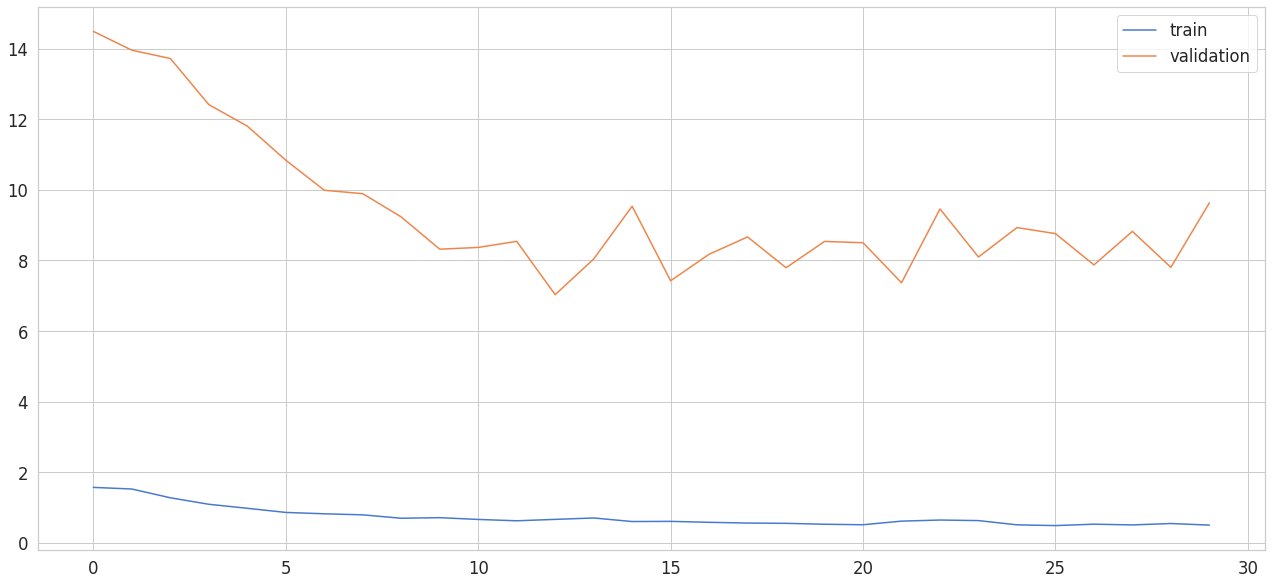

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cases_transformer.inverse_transform(y_train.reshape (1, -1))
y_test_inv = cases_transformer.inverse_transform(y_test.reshape (1, -1))
y_pred_inv = cases_transformer.inverse_transform(y_pred)

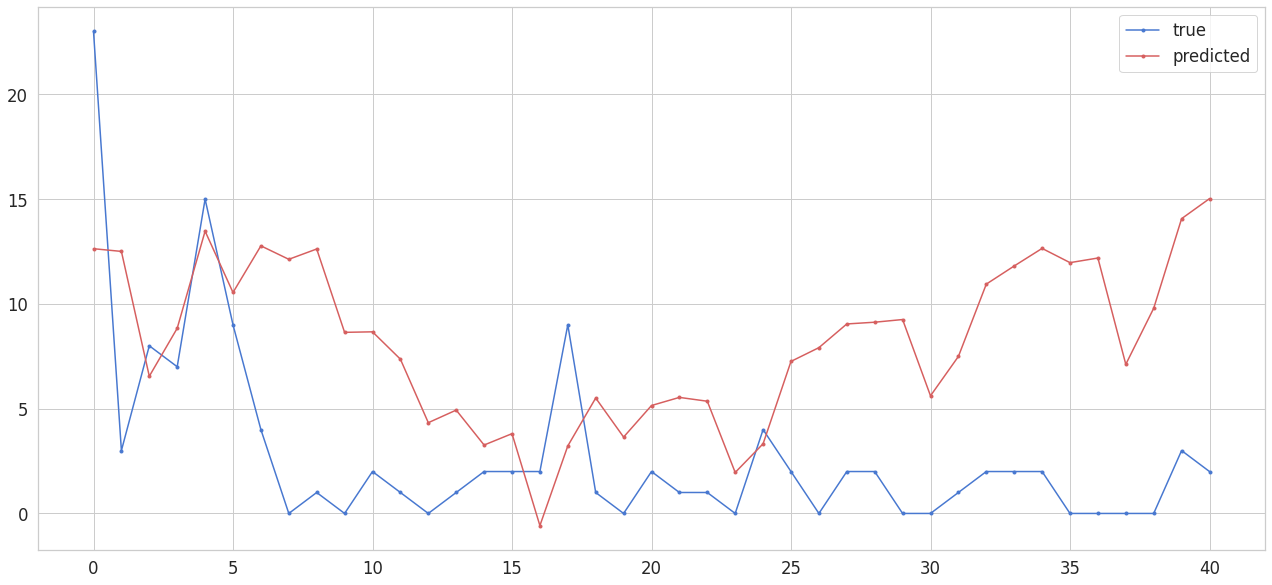

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r', marker='.', label='predicted')
plt.legend()